In [199]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
%autoreload 2

In [201]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
# from waveshare_epd import epd2in7b
from waveshare_epd import epd5in83

In [331]:
import constants
import layouts

In [203]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [287]:
class ImageBlock:
    def __init__(self, image=None, area=(100, 100), abs_coordinates=(0, 0), hcenter=False, vcenter=True, padding=0):
        self.area = area
        self.abs_coordinates = abs_coordinates
        self.hcenter = hcenter
        self.vcenter = vcenter
        self.padding = padding
        self.image = image

    @property
    def area(self):
        return self._area

    @area.setter
    def area(self, area):
        if self.coordcheck(area):
            self._area = area
            logging.debug(f'maximum area: {area}')
        else:
            raise ValueError(f'bad area value: {area}')    

    @property
    def abs_coordinates(self):
        return self._abs_coordinates
    
    @abs_coordinates.setter
    def abs_coordinates(self, abs_coordinates):
        if self.coordcheck(abs_coordinates):
            self.img_coordinates = abs_coordinates
            self._abs_coordinates = abs_coordinates
        else:
            raise ValueError(f'bad absolute coordinates: {abs_coordinates}')
    
    @property
    def image(self):
        '''resize and resample image'''
        return self._image
    
    @image.setter
    def image(self, image):
        dim = min(self.area)-self.padding
        size = (dim, dim)
        im = Image.open(image)
        im.convert(mode='L', colors=2)
        im.thumbnail(size)
        self.dimensions = im.size
        x_new, y_new = self.abs_coordinates
        
        if self.hcenter:
            x_new = self.abs_coordinates[0] + round(self.area[0]/2 - self.dimensions[0]/2)
        if self.vcenter:
            y_new = self.abs_coordinates[1] + round(self.area[1]/2 - self.dimensions[1]/2)
        
        if self.hcenter or self.vcenter:
            self.img_coordinates = (x_new, y_new)
            
        self._image = im
    
    def coordcheck(self, coordinates):
        if not isinstance(coordinates, (tuple, list)):
            raise TypeError(f'must be type(list, tuple): {coordinates}')
        for i, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'must be type(int): {c}')
                return False
            if c < 0:
                raise ValueError(f'coordinates must be positive: {c}')
                return False
        return True            

In [145]:
class TextBlock:
    def __init__(self, area=(600, 448), text=' ', font=None, font_size=24, max_lines=1,
                maxchar=None, hcenter=False, vcenter=False, abs_coordinates=(0,0), 
                chardist=None, image=None):
    
        self.area = area
        if font:
            self.font = ImageFont.truetype(str(Path(font).absolute()), size=font_size)
        else:
            self.font = ImageFont.truetype(str(Path(constants.FONT).absolute()), size=font_size)
        
        if chardist:
            self._chardist = chardist
        else:
            self._chardist = constants.USA_CHARDIST
        self.max_lines = max_lines
        self.maxchar = maxchar
        
        self.hcenter = hcenter
        self.vcenter = vcenter
        
        self.abs_coordinates = abs_coordinates
        
        self.image = image
        
        self.text = text
    


    @property
    def area(self):
        return self._area

    @area.setter
    def area(self, area):
        if self.coordcheck(area):
            self._area = area
            logging.debug(f'maximum area: {area}')
        else:
            raise ValueError(f'bad area value: {area}')
     
    @property
    def maxchar(self):
        '''sets or calculates maximum number of characters per line for a given area based on
            font and font size
        
            If no value is provided, a random string of characters is generated based on the
            frequency tables provided in constants.py. The default distribution is American
            English. Based on this string the maximum number of characters for a given font and 
            font size.
            
        Args
        ----
            maxchar (int): maximum number of characters per line - if no value is provided, this will
                be calculated
        '''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self._maxchar = maxchar
        else:
            s = ''
            n = 1000
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            s_length = self.font.getsize(s)[0] # string length in Pixles
            avg_length = s_length/len(s)
            maxchar = round(self.area[0]/avg_length)
            self._maxchar = maxchar
            logging.debug(f'maximum characters per line: {maxchar}')
    
    @property
    def abs_coordinates(self):
        '''the absolute coordinates for textblock area
            this is the location of the top left corner for this block in the overall image
            
            also sets the absoluote inital coordinates of the text image inside the area. these
            coordinates may be changed depending on centering and other format options
            
        Args
        ----
            abs_coordinates (tuple, list): (int, int)
            
        Sets
        ----
            abs_coordinates (tuple, list): (int, int)
            img_coordinates (tuple, list): (int, int)'''
        return self._abs_coordinates
    
    @abs_coordinates.setter
    def abs_coordinates(self, abs_coordinates):
        if self.coordcheck(abs_coordinates):
            self._abs_coordinates = abs_coordinates
            self.img_coordinates = abs_coordinates
            logging.debug(f'absolute coordinates: {abs_coordinates}')
        else:
            raise ValueError(f'bad absoluote coordinates: {abs_coordinates}')
            
    
    @property
    def text(self):
        '''unformatted raw text
        
        Args
        ----
            text (str): unfomatted raw text
        
        Sets
        ----
            text (str): unformatted raw text
            text_formatted (list): of (str): wrapped text
            image (PIL.Image): image based on wrapped and formatted text'''
        return self._text
    
    @text.setter
    def text(self, text):
        self._text = text
        self.text_formatted = self.text_formatter()
        self.image = self._text2image()
    
    def text_formatter(self, text=None, max_lines=None, maxchar=None):
        '''format text using word-wrap strategies based on number of lines, area
            and maximum characters per line
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters on each line
            max_lines (int): maximum number of lines
            
        Returns
        -------
            ::list of ::str
        '''
        if not text:
            text = self.text
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        
        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        formatted = wrapper.wrap(text)
        logging.debug(f'formatted list:\n {formatted}')
        return(formatted)
    
    def _text2image(self):
        '''produces 1 bit image containging wrapped text and sets image coordinates
            based on image size, hcenter and vcenter rules
        
        Sets
        ----
            dimensions (tuple): of (int) - dimensions of text image
            img_coordinates (tuple): of int - absolute coordinates of text image 
        
        Returns:
            ::tuple :Image.new()
        '''
        
        # determine the extents of the text block image
        y_total = 0
        x_max = 0
        
        for line in self.text_formatted:
            x, y = self.font.getsize(line)
            y_total += y # accumulate the total height
            if x > x_max:
                x_max = x # find the longest line
        
        # set dimensions of the text block image
        self.dimensions = (x_max, y_total)
        logging.debug(f'text image dimensions: {self.dimensions}')
        
        # build image
        image = Image.new('1', self.dimensions, 255)
        # get a drawing context
        draw = ImageDraw.Draw(image)
        
        y_total = 0
        for line in self.text_formatted:
            x_pos = 0
            x, y = self.font.getsize(line)
            if self.hcenter:
                logging.debug(f'h-center line: {line}')
                x_pos = round(self.dimensions[0]/2-x/2)
            draw.text((x_pos, y_total), line, font=self.font)
            y_total += y
        
        # set image coordinates
        new_x, new_y = self.abs_coordinates
        if self.hcenter:
            logging.debug(f'h-center image coordinates')
            new_x = self.abs_coordinates[0] + round(self.area[0]/2 - self.dimensions[0]/2)

            
        if self.vcenter:
            logging.debug(f'v-center image coordinates')
            new_y = self.abs_coordinates[1] + round(self.area[1]/2 - self.dimensions[1]/2)
        
        if self.hcenter or self.vcenter:
            logging.debug(f'image coordinates {(new_x, new_y)}')
            self.img_coordinates = (new_x, new_y)
        
        return image
    
    
    def coordcheck(self, coordinates):
        if not isinstance(coordinates, (tuple, list)):
            raise TypeError(f'must be type(list, tuple): {coordinates}')
        for i, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'must be type(int): {c}')
                return False
            if c < 0:
                raise ValueError(f'coordinates must be positive: {c}')
                return False
        return True

In [353]:
class Screen:
    def __init__(self, resolution=(600, 448), elements=[], epd=None):
        self.resolution = resolution
        self.elements = elements
        self.image = self.clearScreen()
        self.epd = epd
        
    def clearScreen(self):
        '''sets a clean base image for building screen layout
        
        Returns
        -------
            ::Image.new
        '''
        image = Image.new('L', self.resolution, 255)
        return image
    
    def concat(self, elements=None):
        if elements:
            elements = elements
        else:
            elements = self.elements
            
        for e in elements:
            logging.debug(f'pasing image at: {e.img_coordinates}')
            self.image.paste(e.image,  e.img_coordinates)
        return(self.image)
    
    def initEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.init()
        except Exception as e:
            logging.error(f'failed to init epd: {e}')
    
    def clearEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.Clear();
        except Exception as e:
            logging.error(f'failed to clear epd: {e}')
    
    def writeEPD(self, image=None, sleep=True):
        epd = self.epd
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
#             epd.display(epd.getbuffer(self.image), epd.getbuffer(Image.new('1', (epd.height, epd.width), 255)))
            epd.display(epd.getbuffer(self.image))
            if sleep:
                epd.sleep()
        except Exception as e:
            logging.error(f'failed to write to epd: {e}')
        

In [354]:
class Layout:
    def __init__(self, resolution=(600, 448), layout=None, font=constants.FONT):
        self.resolution = resolution
        self.font = str(Path(font).absolute())
        self.layout = copy.deepcopy(layout)
        self.images = None

    def _check_keys(self, dictionary={}, values={}):
        logging.debug('checking key/values')
        for k, v in values.items():
            try:
                dictionary[k]
            except KeyError as e:
                logging.debug(f'missing key: {k}; adding and setting to {v}')
                dictionary[k] = v
        return dictionary
    
    def _scalefont(self, font=constants.FONT, lines=1, text="W", resolution=(100, 100)):
        # start at fontsize 1 
        fontsize = 1
        y_fraction = .7
        target = resolution[1]/lines*y_fraction

        font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)

        fontdim = font.getsize(text)

        # work up until font covers img_fraction of the resolution return one smaller than this as the fontsize
        while fontdim[1] < target:
            fontdim = font.getsize(text)
            fontsize +=1
            font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)
        fontsize -= 1
        logging.debug(f'target Y fontsize: {target}, fontsize: {fontsize}, fontdim: {fontdim}')
        
        return(fontsize)    
    
    @property
    def layout(self):
        return self._layout
    
    @layout.setter
    def layout(self, layout):
        logging.debug(f'calculating values from layout for resolution {self.resolution}')
        if not layout:
            self._layout = None
        self._layout = self.calculate_layout(layout)
    
    
    def calculate_layout(self, layout):
        l = layout
        resolution = self.resolution
        # required values that will be used in calculating the layout
        values = {'image': None, 'max_lines': 1, 'padding': 0, 'width': 1, 'height': 1, 
                  'abs_coordinates': (0, 0), 'hcenter': False, 'vcenter': False, 'relative': False, 
                  'font': self.font, 'fontsize': None, 'dimensions': None}        
        for section in l:
            logging.debug(f'***{section}***')
            this_section = self._check_keys(l[section], values)
                    
            dimensions = (round(resolution[0]*this_section['width']), 
                          round(resolution[1]*this_section['height']))
            
            this_section['dimensions'] = dimensions
            logging.debug(f'dimensions: {dimensions}')       
        
            # set the thumbnail_size to resize the image
            if this_section['image']:
                maxsize = min(this_section['dimensions'])-this_section['padding']*2
                this_section['thumbnail_size'] = (maxsize, maxsize)
            
            # calculate the relative position if needed
            # if either of the coordinates are set as "None" - attempt to calculate the position
            if this_section['abs_coordinates'][0] is None or this_section['abs_coordinates'][1] is None:
                logging.debug(f'has calculated position')
                # store coordinates
                pos = []
                # check each value in relative section
                for idx, r in enumerate(this_section['relative']):
                    if r == section:
                        # use the value from this_section
                        pos.append(this_section['abs_coordinates'][idx])
                    else:
                        # use the value from another section
                        pos.append(l[r]['dimensions'][idx] + l[r]['abs_coordinates'][idx])
                
                # save the values as a tuple
                this_section['abs_coordinates']=(pos[0], pos[1])
            else:
                logging.debug('has explict position')
            logging.debug(f'abs_coordinates: { this_section["abs_coordinates"] }')
                          
            # calculate fontsize
            if this_section['max_lines']:
                if not this_section['font']:
                    this_section['font'] = self.font
                          
                if not this_section['fontsize']:
                    this_section['fontsize'] = self._scalefont(font=this_section['font'], 
                                                               resolution=this_section['dimensions'],
                                                               lines=this_section['max_lines'])    
                logging.debug(f'font size: {this_section["fontsize"]}')

            l[section] = this_section    
        return l
                              
    def set_images(self, layout=None):
        if not layout:
            layout = self.layout
        
        blocks = {}
        for sec in layout:
            section = layout[sec]
            # any section with max lines accepts text
            if section['max_lines']:
                logging.debug(f'***{sec}***)')
                logging.debug('set text block')
                blocks[sec] = TextBlock(area=section['dimensions'], text='.', font=section['font'], 
                                       font_size=section['fontsize'], max_lines=section['max_lines'],
                                       hcenter=section['hcenter'], vcenter=section['vcenter'],
                                       abs_coordinates=section['abs_coordinates'])
        self.blocks = blocks

In [376]:
%autoreload 2

In [377]:
# l = Layout(layout=layouts.twoColumn)
l = Layout(layout=layouts.threeRow)

DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***title***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (600, 269)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:target Y fontsize: 94.14999999999999, fontsize: 88, fontdim: (81, 95)
DEBUG:root:font size: 88
DEBUG:root:***coverart***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (200, 179)
DEBUG:root:has calculated position
DEBUG:root:abs_coordinates: (0, 269)
DEBUG:root:***artist***
DEBUG:root:checking key/values
DEBUG:root:missing key: dimensions; adding and setting to None
DEBUG:root:dimensions: (400, 90)
DEBUG:root:has calculated position
DEBUG:root:abs_coordinates: (200, 269)
DEBUG:root:target Y fontsize: 31.499999999999996, fontsize: 30, fontdim: (28, 33)
DEBUG:root:font size: 30
DEBUG:root:***album***
DEBUG:root:checking key/val

In [378]:
l.layout = l.calculate_layout(l._layout)

DEBUG:root:***title***
DEBUG:root:checking key/values
DEBUG:root:dimensions: (600, 269)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:font size: 88
DEBUG:root:***coverart***
DEBUG:root:checking key/values
DEBUG:root:dimensions: (200, 179)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 269)
DEBUG:root:***artist***
DEBUG:root:checking key/values
DEBUG:root:dimensions: (400, 90)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (200, 269)
DEBUG:root:font size: 30
DEBUG:root:***album***
DEBUG:root:checking key/values
DEBUG:root:dimensions: (400, 90)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (200, 359)
DEBUG:root:font size: 30
DEBUG:root:calculating values from layout for resolution (600, 448)
DEBUG:root:***title***
DEBUG:root:checking key/values
DEBUG:root:dimensions: (600, 269)
DEBUG:root:has explict position
DEBUG:root:abs_coordinates: (0, 0)
DEBUG:root:font size: 88
DEBUG:root:***coverart***
DEBUG:root:checking

In [379]:
l.set_images()

DEBUG:root:***title***)
DEBUG:root:set text block
DEBUG:root:maximum area: (600, 269)
DEBUG:root:maximum characters per line: 12
DEBUG:root:absolute coordinates: (0, 0)
DEBUG:root:formatted list:
 ['.']
DEBUG:root:text image dimensions: (23, 96)
DEBUG:root:h-center line: .
DEBUG:root:h-center image coordinates
DEBUG:root:v-center image coordinates
DEBUG:root:image coordinates (288, 86)
DEBUG:root:***artist***)
DEBUG:root:set text block
DEBUG:root:maximum area: (400, 90)
DEBUG:root:maximum characters per line: 24
DEBUG:root:absolute coordinates: (200, 269)
DEBUG:root:formatted list:
 ['.']
DEBUG:root:text image dimensions: (8, 33)
DEBUG:root:v-center image coordinates
DEBUG:root:image coordinates (200, 297)
DEBUG:root:***album***)
DEBUG:root:set text block
DEBUG:root:maximum area: (400, 90)
DEBUG:root:maximum characters per line: 24
DEBUG:root:absolute coordinates: (200, 359)
DEBUG:root:formatted list:
 ['.']
DEBUG:root:text image dimensions: (8, 33)
DEBUG:root:v-center image coordinate

In [380]:
l.blocks['title'].text = 'Luckiest Man In the World'
l.blocks['artist'].text = "Wood Brothers"
l.blocks['album'].text = "ways not to loose"

DEBUG:root:formatted list:
 ['Luckiest Man', 'In the World']
DEBUG:root:text image dimensions: (537, 192)
DEBUG:root:h-center line: Luckiest Man
DEBUG:root:h-center line: In the World
DEBUG:root:h-center image coordinates
DEBUG:root:v-center image coordinates
DEBUG:root:image coordinates (32, 38)
DEBUG:root:formatted list:
 ['Wood Brothers']
DEBUG:root:text image dimensions: (211, 33)
DEBUG:root:v-center image coordinates
DEBUG:root:image coordinates (200, 297)
DEBUG:root:formatted list:
 ['ways not to loose']
DEBUG:root:text image dimensions: (244, 40)
DEBUG:root:v-center image coordinates
DEBUG:root:image coordinates (200, 384)


In [381]:
ca = ImageBlock('./cover.jpg', area=(150, 179), abs_coordinates=(0, 269), hcenter=True, vcenter=True, padding=10)

DEBUG:root:maximum area: (150, 179)


DEBUG:root:pasing image at: (5, 289)
DEBUG:root:pasing image at: (32, 38)
DEBUG:root:pasing image at: (200, 297)
DEBUG:root:pasing image at: (200, 384)


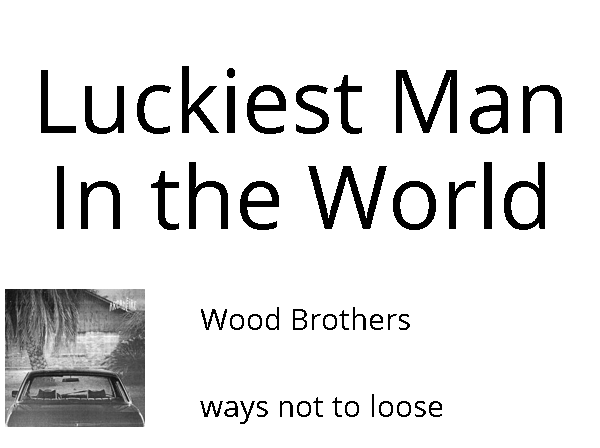

In [382]:
s = Screen()
s.elements = [ca, l.blocks['title'], l.blocks['artist'], l.blocks['album']]
s.clearScreen()
s.concat()


In [383]:
e = epd5in83.EPD()

In [384]:
s.epd = e
s.initEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release


In [385]:
s.writeEPD()

DEBUG:root:imwidth = 600  imheight =  448 
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...
